# Exploratory Data Analysis

**Arun Godwin Patel**

Exploratory Data Analysis (EDA) is an essential tool in the Data Science toolbox. It is the process of understanding your dataset using statistical techniques and visualizations. The insight that you gain from EDA can help you to uncover issues, dra

## Titanic Dataset
This dataset is from https://github.com/awesomedata/awesome-public-datasets/tree/master/Datasets

In [1]:
from hana_ml import dataframe
from hana_ml.algorithms.pal import trees
from hana_ml.visualizers.eda import EDAVisualizer as eda
import pandas as pd
import matplotlib.pyplot as plt
import time
from hana_ml.visualizers.eda import EDAVisualizer, hist, kdeplot

In [2]:
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_titanic_data(connection_context, force=False, batch_size=50000)

Table TITANIC_FULL_TBL exists and data exists


In [3]:
# Create the HANA Dataframe (df_train) and point to the training table.
data = connection_context.table(full_tbl)
data.head(5).collect()

,PASSENGER_ID,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,SURVIVED
0,813,2,"Slemen\, Mr. Richard James",male,35.0,0,0,28206,10.5000,None,S,0
1,609,2,"Laroche\, Mrs. Joseph (Juliette Marie Louise L...",female,22.0,1,2,SC/Paris 2123,41.5792,None,C,1
2,443,3,"Petterson\, Mr. Johan Emil",male,25.0,1,0,347076,7.7750,None,S,0
3,228,3,"Lovell\, Mr. John Hall (\Henry\"")""",male,20.5,0,0,A/5 21173,7.2500,None,S,0
4,713,1,"Taylor\, Mr. Elmer Zebley",male,48.0,1,0,19996,52.0000,C126,S,1


In our dataset we have 12 columns:
- **PassengerId** - Unique ID assigned to each passenger.
- **Pclass** - Class of ticket purchased (1 = 1st class, 2 = 2nd class, 3 = 3rd class).
- **Name** - Full name and title of the passenger.
- **Sex** - Gender of the passenger.
- **Age** - The Age of the passenger in years.
- **SibSp** - Number of siblings and spouses associated with the passenger aboard.
- **Parch** - Number of parents and children associated with the passenger aboard.
- **Ticket** - Ticket number.
- **Fare** - The fare of the ticket purchased by the passenger.
- **Cabin** - The Cabin number that the passenger was assigned to. If NaN, this means they had no cabin and perhaps were not assigned one due to the cost of their ticket.
- **Embarked** - Port of embarkation (S = Southampton, C = Cherbourg, Q = Queenstown).
- **Survived** - Survival flag of passenger.

In [4]:
data.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,PASSENGER_ID,1091,1091,0,546.000000,315.088876,1.0,1091.0000,546.0000,273.5000,273.0000,546.0000,546.0000,818.5,819.0
1,PCLASS,1091,3,0,2.303391,0.839712,1.0,3.0000,3.0000,2.0000,2.0000,3.0000,3.0000,3.0,3.0
2,AGE,1091,96,0,23.914913,17.592688,0.0,80.0000,24.0000,8.0000,8.0000,24.0000,24.0000,35.0,35.0
3,SIBSP,1091,7,0,0.513291,1.076247,0.0,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
4,PARCH,1091,7,0,0.385885,0.829801,0.0,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
5,FARE,1091,271,0,32.895012,51.102808,0.0,512.3292,14.4542,7.8958,7.8958,14.4542,14.4542,31.0,31.0
6,SURVIVED,1091,2,0,0.342805,0.474864,0.0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
7,NAME,1091,1089,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,SEX,1091,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,TICKET,1091,806,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This description is useful to first understand some basic statistics over a dataset. We are presented with:
- **Column**: Name of the column
- **Count**: Count of rows for this column
- **Unique**: Distinct count of this column
- **Nulls**: Total rows with null values for this column
- **Mean**: Sum of the column divided by the count
- **Std**: Standard deviation, a quantity expressing by how much the members of a group differ from the mean value for the group
- **Min**: Minimum value of the column
- **Max**: Maximum value of the column
- **Median**: The 50th percentile value (percentiles explained below)
- **25, 50 & 75 percentiles**: A percentile is the value that represents a division of the ordered dataset by a certain %. For example, the 10th percentile is the value that when the dataset is ordered, splits the bottom 10% from the remaining 90%. e.g. you have numbers:

### 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

**What is the 10th percentile? The dataset is already ordered, now we must simply split the data after 10% of the values.**

### 1 2   |   3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

Hence, it equals 2.

Percentiles are useful to understand the lower (25%), middle (50% AKA median) and upper (75%) quartiles. This is useful when calculating the inter-quartile range, which is a way of understanding the spread (dispersion) of values within data. It is calculated by the difference between the upper and lower quartile. The IQR also gives you an indication of the spread of the middle 50% of values within your column.

### Distribution plot

- Displaying the distribution shows us how the values of a column are spread in regards to frequency.
- By looking at the x axis bins, we can see the range of values that occured for the column.
- Looking at a distribution can give you an indication on how skewed your column is from the normal distribution. This is important to know because highly positive or negatively skewed data can cause a predictive model to overfit to extreme values.
- Extreme values are large values that could be considered as outliers, and may skew results of a Machine Learning model.

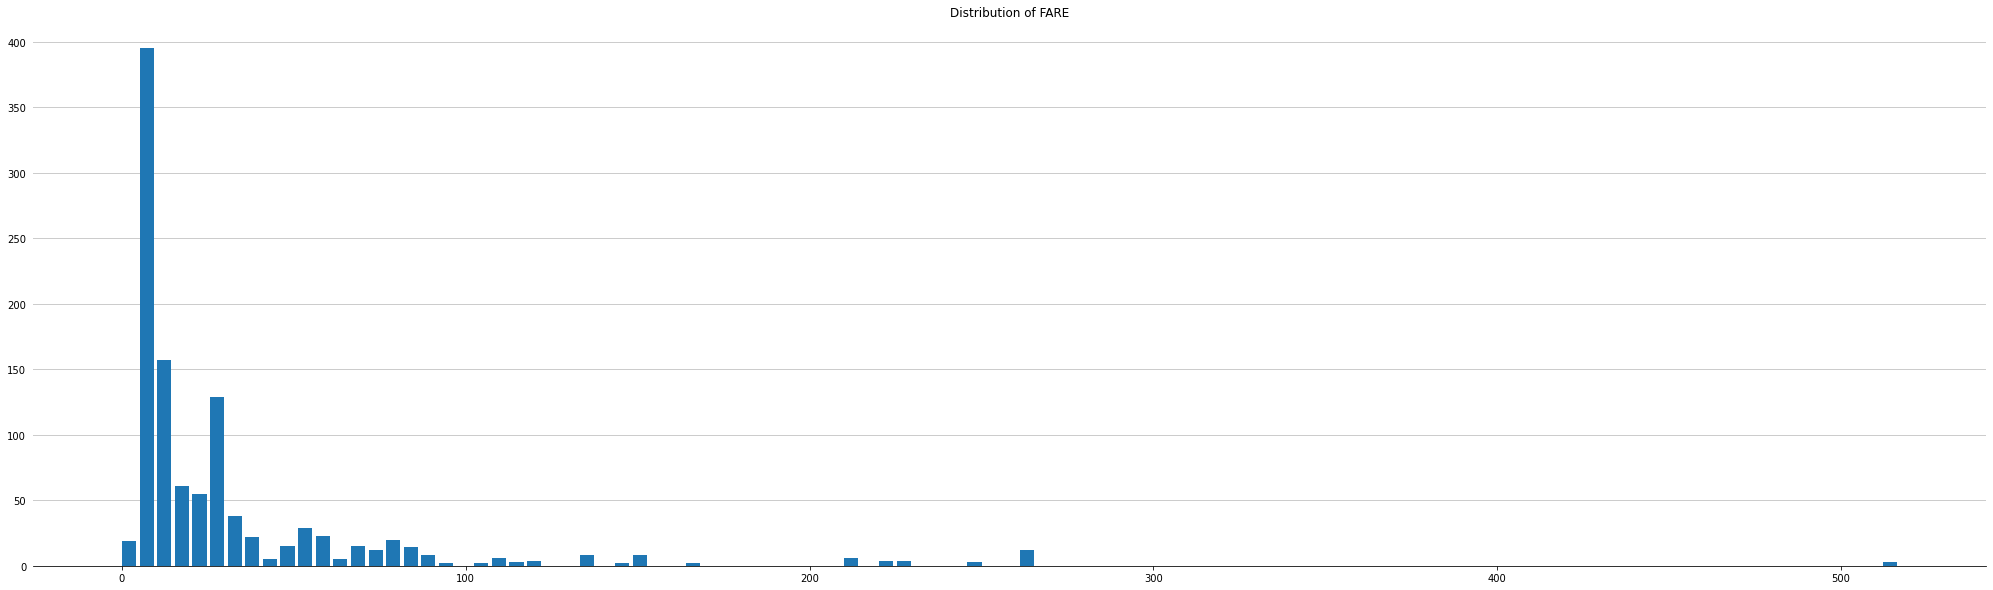

In [5]:
f = plt.figure(figsize=(35, 10))

ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, dist_data = eda.distribution_plot(data=data, column="FARE", bins=100, title="Distribution of FARE")

plt.show()

### Distribution plot for AGE between survivors and non-survivors

- The distributions of age for survivors and non-survivors follow a very similar distribution. 
- This tells us that the column 'AGE' may not be a highly significant factor in predicting survival, because it follows a very similar pattern for survivors/non-survivors.

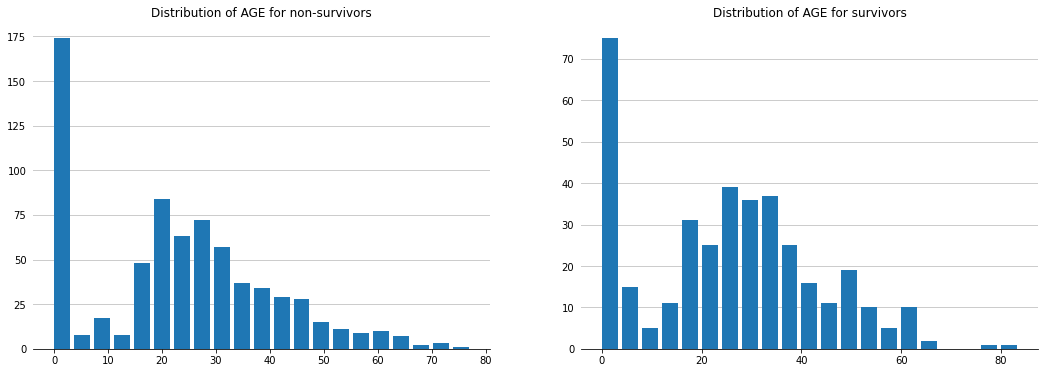

In [6]:
f = plt.figure(figsize=(18, 6))

ax1 = f.add_subplot(121)
eda = EDAVisualizer(ax1)
ax1, dist_data = eda.distribution_plot(data=data.filter("SURVIVED = 0"), column="AGE", bins=20, title="Distribution of AGE for non-survivors")

ax1 = f.add_subplot(122)
eda = EDAVisualizer(ax1)
ax1, dist_data = eda.distribution_plot(data=data.filter("SURVIVED = 1"), column="AGE", bins=20, title="Distribution of AGE for survivors")

plt.show()

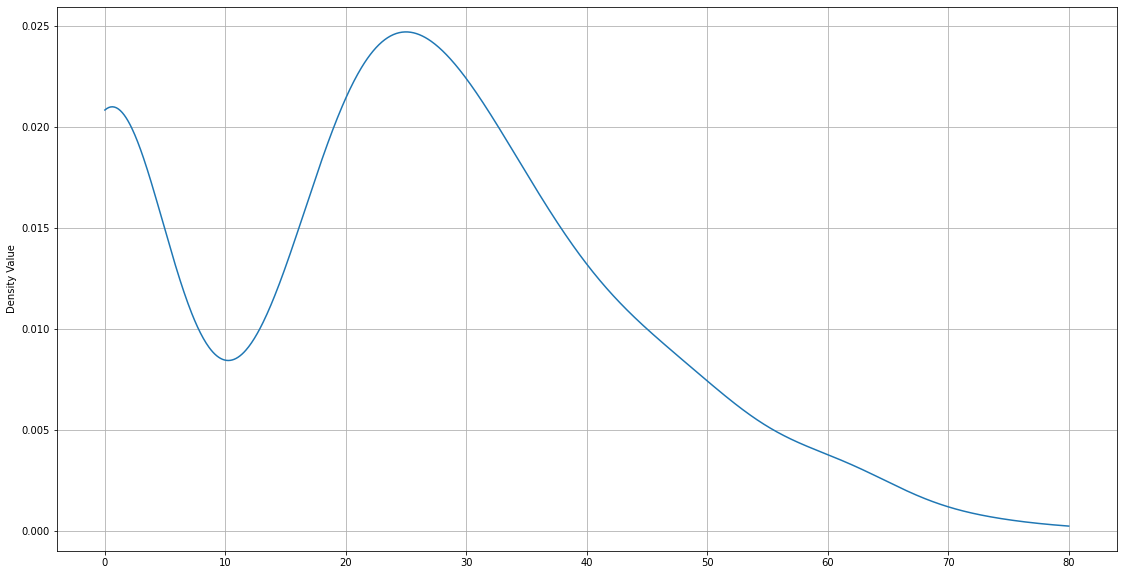

In [7]:
f = plt.figure(figsize=(19, 10))

ax = kdeplot(data, key="PASSENGER_ID", features=["AGE"])
ax.grid()
plt.show()

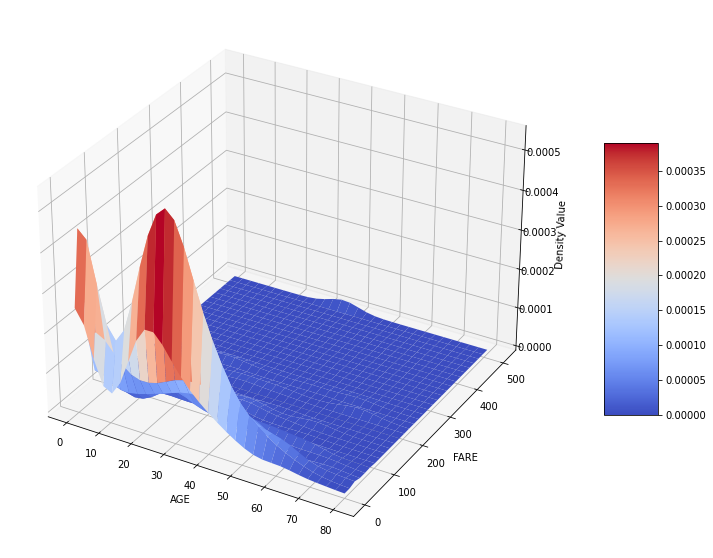

In [8]:
f = plt.figure(figsize=(19, 10))

ax, surf = kdeplot(data, key="PASSENGER_ID", features=["AGE", "FARE"])
ax.grid()
plt.show()

### Pie plot

- A pie plot shows us the distribution of values between categories as a percentage.
- These are particulalrly useful for categorical columns.
- Each coloured portion of the pie plot is labelled to represent a different value within the column.
- The size of the coloured portion is proportional to the percentage of occurences this value takes.

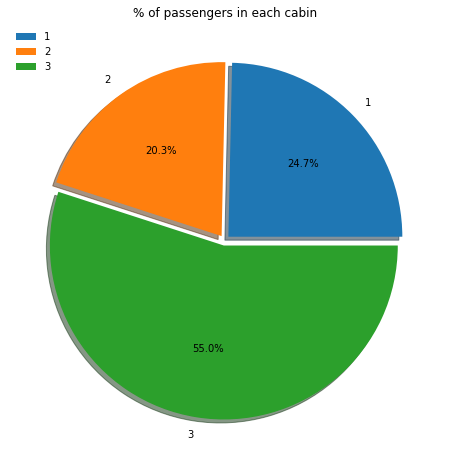

In [9]:
f = plt.figure(figsize=(8, 8))

ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, pie_data = eda.pie_plot(data, column="PCLASS", title="% of passengers in each cabin")

plt.show()

### Pie plot for PCLASS distribution between survivors and non-survivors

- We can see that the percentage of survivors and non-survivors varied quite largely between cabins, for example the percentage of non-survivors in the 1st class cabin was 14.4% but the percentage of survivors that were in 1st class was 44.4%.
- It shows us that the largest majority of non-survivors came from 3rd class, and the largest majority of survivors came from 1st class.

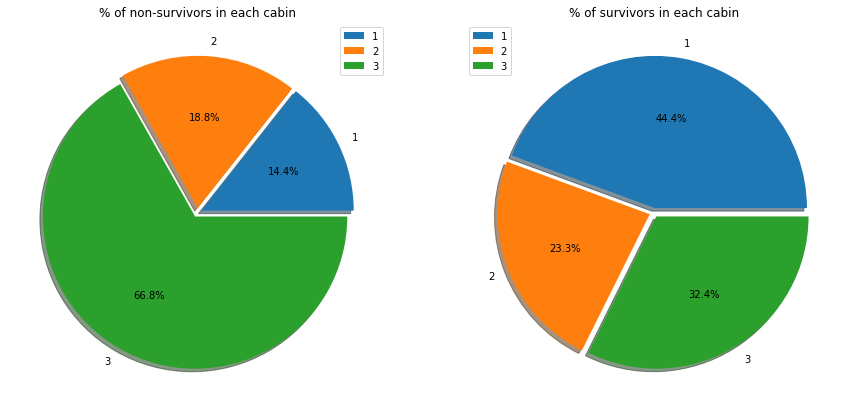

In [10]:
f = plt.figure(figsize=(15, 8))

ax1 = f.add_subplot(121)
eda = EDAVisualizer(ax1)
ax1, pie_data = eda.pie_plot(data=data.filter("SURVIVED = 0"), column="PCLASS", title="% of non-survivors in each cabin")
ax1.legend(loc='best') # User has control over axis aesthetics

ax1 = f.add_subplot(122)
eda = EDAVisualizer(ax1)
ax1, pie_data = eda.pie_plot(data=data.filter("SURVIVED = 1"), column="PCLASS", title="% of survivors in each cabin")
ax1.legend(loc='best') # User has control over axis aesthetics

plt.show()

### Correlation plot

- A nice way to understand the linear relationship between multiple variables is by using a correlation matrix.
- The values shown in the matrix range from -1 to 1 and are calculations of Pearson's correlation coefficient (r). The 'r' value tells us the extent to which the variance of 2 columns follow a linear relationship. For example:
    - If r = -1 for FARE and AGE, this tells me that as FARE increases, AGE proportionally decreases.
    - If r = 1 for FARE and AGE, this tells me that as FARE increases, AGE also proportionally increases.
    - A correlation of 1 or -1 would be very suspicious and would indicate that these columns may contain similar information.
    - If r = 0 for FARE and AGE, this tells me that FARE and AGE have no linear relationship and are in fact, independant.
- We can see here that 'PARCH' and 'SIBSP' are the highest correlating numeric features. With Machine Learning, we ideally want a set of independant variables, highly correlating variables can cause multicolinearity, which causes skewed results due to leaker variables.

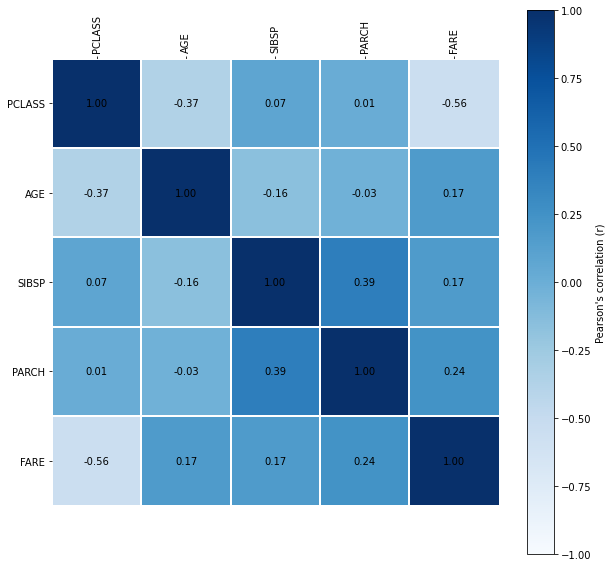

In [11]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.correlation_plot(data=data, corr_cols=['PCLASS', 'AGE', 'SIBSP', 'PARCH', 'FARE'], cmap="Blues")

plt.show()

### Histograms

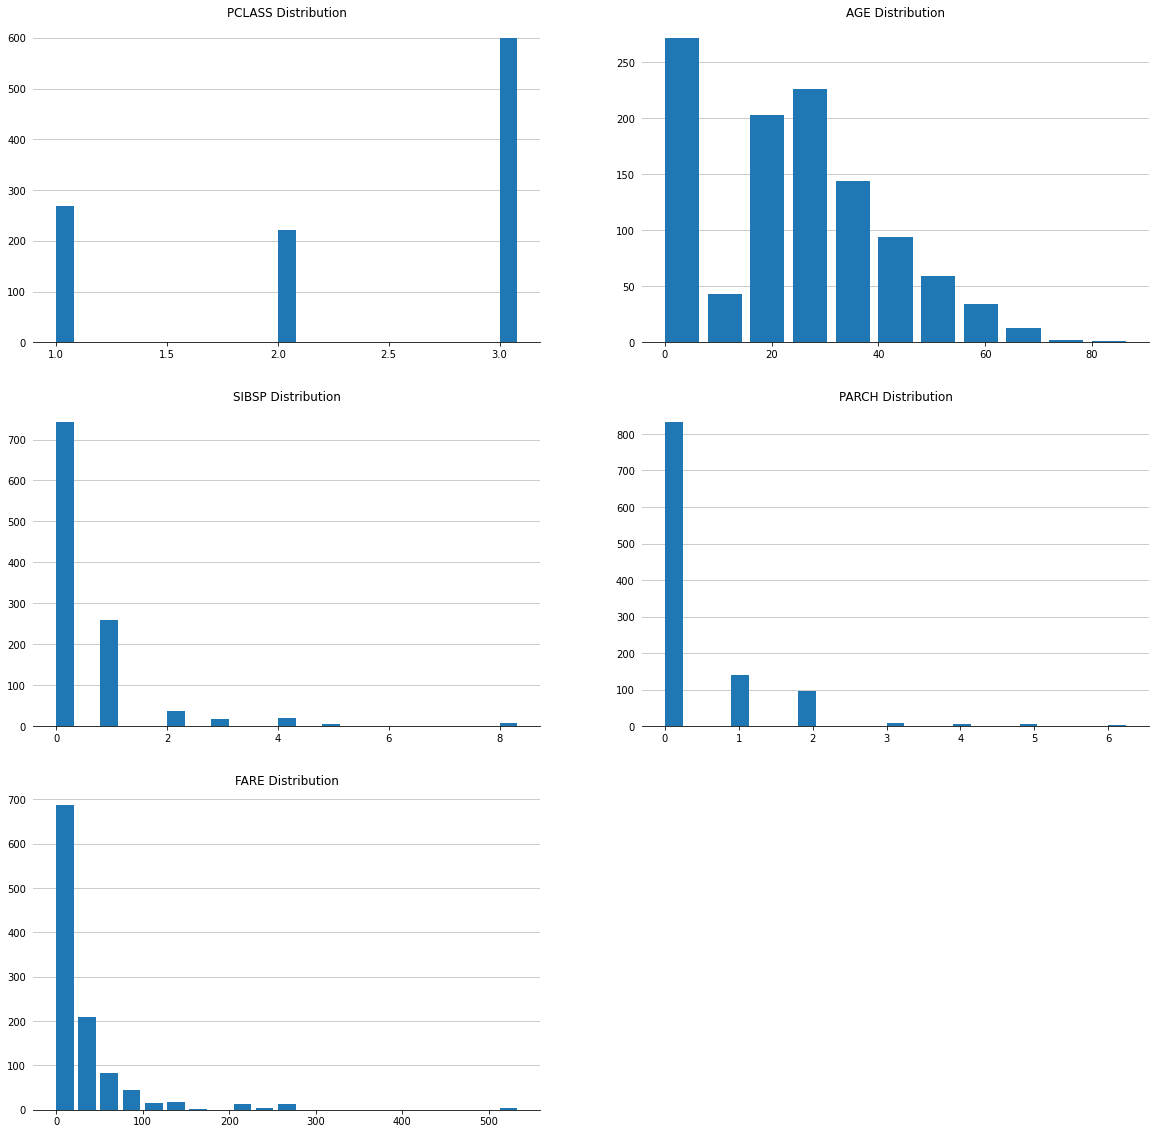

In [12]:
hist(data=data, columns=['PCLASS', 'AGE', 'SIBSP', 'PARCH', 'FARE'], default_bins=20, bins={"AGE": 10})

### Scatter plot

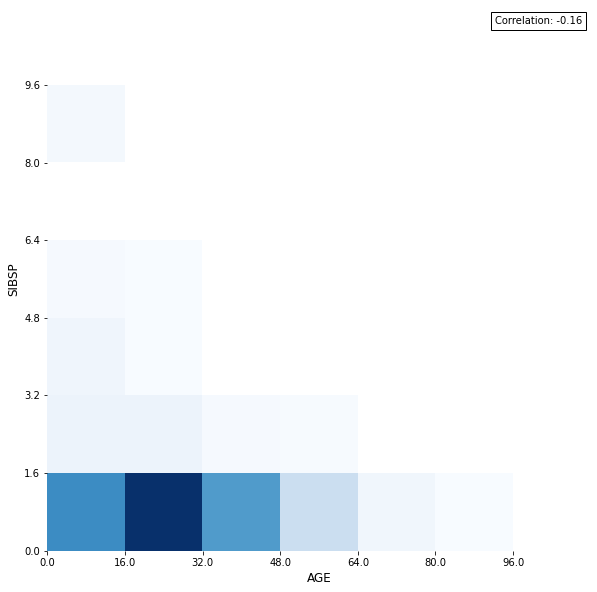

In [13]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.scatter_plot(data=data, x="AGE", y="SIBSP", x_bins=5, y_bins=5)
plt.show()

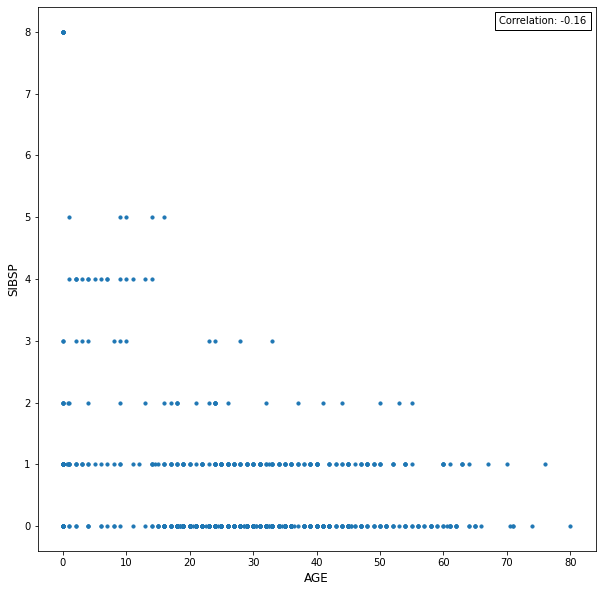

In [14]:
f = plt.figure(figsize=(10,10))
ax2 = f.add_subplot(111)
eda = EDAVisualizer(ax2)
ax2 = eda.scatter_plot(data=data, x="AGE", y="SIBSP", sample_frac=0.8, s=10, marker='o')
plt.show()

### Box plot

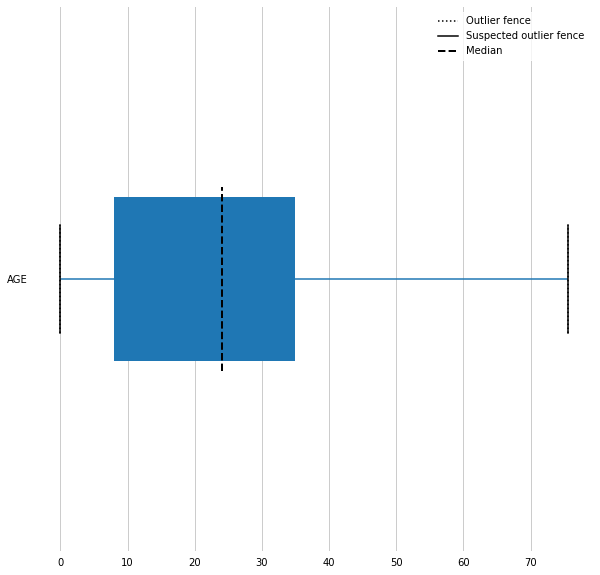

In [15]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.box_plot(data=data, column="AGE")
plt.show()

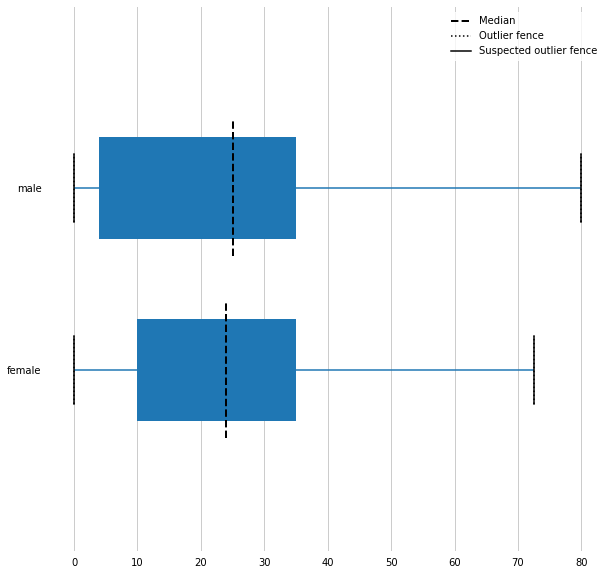

In [16]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.box_plot(data=data, column="AGE", groupby="SEX")
plt.show()

In [17]:
# Close the connection to SAP HANA
connection_context.close()